# EGFR & mutation benchmark

**EGFR (Epidermal Growth Factor Receptor) kinase** is a type of receptor tyrosine kinase that plays a significant role in cell growth, proliferation, and survival. Mutations or overexpression of EGFR have been associated with various diseases, particularly cancer.

- **EGFR Wild type**:  Targeting wild-type EGFR with small-molecule inhibitors, such as erlotinib, is an ongoing area of research in the treatment of glioblastoma. While early findings are promising, the complexity of glioblastoma biology presents challenges that require further investigation to improve treatment outcomes for patients.
- **EGFR L858R:** While EGFR TKIs initially demonstrate impressive responses in NSCLC patients with the L858R mutation, resistance to these drugs can develop over time. However, newer generations of EGFR TKIs, like osimertinib, have been developed to target these resistant mutations.

**Published EGFR datasets**: 
- **PKIS 1**: A set of 364 unique small-molecule ATP-competitive kinase inhibitors that was screened by the set in activity assays with 224 recombinant kinases and 24 G protein-coupled receptors and in cellular assays of cancer cell proliferation and angiogenesis ([ref](https://pubmed.ncbi.nlm.nih.gov/26501955/)).

**Description of readout:**
- **Readouts**: `EGFR_(L858R_mutant)`, `EGFR`
- **Bioassay readout**: Percentage of inhnibition.
- **Optimization objective**: Higher the more potent.

**The goal** of this benchmark is to select the best predictive model for 
- Optimization of the bioactivity % inhibition.
- Discovery of potential hits in new chemical space.

Therefore, a scaffold-based splitting approach was applied to ensure training and test sets contain distinct chemical structures while maintaining the diversity of scaffolds.

See more details in the dataset information.  

In [1]:
%load_ext autoreload
%autoreload 2
import datamol as dm
import pandas as pd
import polaris
from polaris import curation
import numpy as np
import umap
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os import path
from os.path import dirname
os.chdir(path.dirname(path.dirname(path.abspath("__file__"))))

import pandas as pd
import datamol as dm
import numpy as np
from sklearn.model_selection import ShuffleSplit

from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.benchmark import SingleTaskBenchmarkSpecification, MultiTaskBenchmarkSpecification
from utils import display_umap, load_readme, save_figure

/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/d

## Dataset creation with `Polaris`
The first step of creating a benchmark is to set up a standard dataset which allows accessing the curated dataset (which has been demonstrated in <01_EGFR_mutants_data_curation.ipynb>), and all necessary information about the dataset such as data source, description of endpoints, units etc. 

In [2]:
from polaris.utils.types import HubOwner
owner = HubOwner(organizationId="PolarisTest", slug="polaristest")
owner.owner

'PolarisTest'

In [3]:
BENCHMARK_DIR = "gs://polaris-public/benchmarks/kinases/egfr"
DATASET_DIR = "gs://polaris-public/datasets/kinases/egfr"
FIGURE_DIR = "gs://polaris-public/datasets/kinases/egfr/figures"

### Load existing data
> **Attention:** \
> The original dataset is published in https://pubmed.ncbi.nlm.nih.gov/26501955 \
> 
> To **maintain consistency** with other benchmarks in the Polaris Hub, a thorough data curation process is carried out to ensure the accuracy of molecular presentations.
> Therefore, the raw data from the data resource is not used here. 
> See more curation details in [01_EGFR_mutants_data_curation.ipynb](https://github.com/polaris-hub/polaris-recipes/blob/mvp/03_Kinases/EGFR/mutants/01_EGFR_mutants_data_curation.ipynb)


In [4]:
# Load data
PATH = 'gs://polaris-public/Data/Kinases/EGFR_mutants_curated.parquet'
table = pd.read_parquet(PATH)

In [5]:
data_cols = ['EGFR_(L858R_mutant)', 'EGFR']
mol_col = "smiles"

Not all the columns are necessary, only the columns which are useful for the benchmarks will be annotated. Here we only use the columns that were used for training in the original paper. 

It's necessary to specify the key bioactivity columns, molecules structures and identifiers in dataset with `ColumnAnnotation`. It is possible to add `user_attributes` with any key and values when is needed, such as `unit`, `organism`, `scale` and optimization `objective`. 

**Abbrevations for the endpoint objective**
- THTB: the higher the better
- TLTB: the lower the better

In [6]:
# threshold for inhibitors
th = 80
annotations = {
     'UNIQUE_ID': ColumnAnnotation(description='Molecular hash ID. See <datamol.mol.hash_mol>'),
     'smiles': ColumnAnnotation(description='Molecule SMILES string'),
     'EGFR_(L858R_mutant)': ColumnAnnotation(description='Percentage of inhibition on EGFR with mutation L858R_mutant', user_attributes={'unit': '%', 'concentration': '1uM', 'organism': 'human', 'objective': 'THTB', 'source': 'PKIS1', 'mutation': 'L858R_mutant', 'target': 'EGFR'}),
     'EGFR': ColumnAnnotation(description='Percentage of inhibition on EGFR wide type', user_attributes={'unit': '%', 'concentration': '1uM', 'organism': 'human', 'objective': 'THTB', 'source': 'https://pubmed.ncbi.nlm.nih.gov/26501955', 'mutation': 'None', 'target': 'EGFR'}),
     'CLASS_EGFR_(L858R_mutant)': ColumnAnnotation(description='Binarized label based on the percentage of inhibition on EGFR L858R_mutant', user_attributes={'thresholds': f'[{th}]', 'label_order': 'ascending', 'ref_col': 'EGFR_(L858R_mutant)'}),
     'CLASS_EGFR': ColumnAnnotation(description='Binarized label based on the percentage of inhibition on EGFR wide type', user_attributes={'thresholds': f'[{th}]', 'label_order': 'ascending', 'ref_col': 'EGFR'})
}

### Create `Dataset` object

In [7]:
import datamol as dm
dataset_name= "egfr_wt_l858r_v1"
with dm.fs.fsspec.open(f"gs://polaris-public/datasets/readmes/{dataset_name}_readme.md") as f:
    dataset_readme = f.read()

In [8]:
dataset = Dataset(
    table=table[list(annotations.keys())],
    name=dataset_name,
    description=f"Profile of kinase EGFR, and its mutant EGFR_(L858R_mutant)",
    source="https://pubmed.ncbi.nlm.nih.gov/26501955",
    annotations=annotations,
    owner=owner,
    tags=["Kinase", "Multitask", "HitDiscovery"], 
    readme = dataset_readme
)

In [9]:
# save the dataset
SAVE_DIR = f"{DATASET_DIR}/{dataset_name}"
dataset.to_json(SAVE_DIR)

'gs://polaris-public/datasets/kinases/egfr/egfr_wt_l858r_v1/dataset.json'

## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-validation-test set and defining evaluation metrics which is used to establish baseline performance level. 

### Create scaffold split for `EGFR` dataset
> **Note:**
> Here we use splitting tool `Splito` to split dataset to train and test. \
> [Splito](https://github.com/datamol-io/splito) is a machine learning dataset splitting library for life sciences.

The objective is to comprehend the proficiency of a model in predicting these 'easy' properties. \
In order to select the predictive models which is able to generalize to new chemical space, a scaffold split is used to generate trian/test sets. 

In [10]:
# scaffold split
from partitio._scaffold_split import ScaffoldSplit
flag = True
nums_pos_test = []
TEST_SIZE = 0.2
SEED = 846
splitter = ScaffoldSplit(smiles=dataset.table.smiles.values, n_jobs=-1, test_size=TEST_SIZE, random_state=SEED)
scaffold_split = next(splitter.split(X=dataset.table.smiles.values))

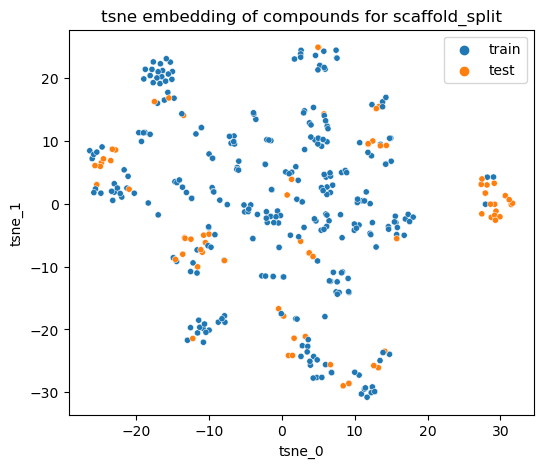

In [15]:
from utils import display_umap
fig = display_umap(table, 'smiles', split =scaffold_split, 
                   split_name="scaffold_split")
save_figure(fig,f"{FIGURE_DIR}/{dataset_name}_umap_scaffold_split.png", 
            f"figures/{dataset_name}_umap_scaffold_split.png" )

## Define multitask benchmarks for EGFR and L858R mutant with scaffold split

**Regression tasks**

In [16]:
benchmark_name ="egfr_wt_l858r_multitask_reg_v1"
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"

benchmark_reg = MultiTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=data_cols,
    input_cols="smiles",
    split=scaffold_split,
    main_metric="mean_squared_error",
    metrics=["mean_absolute_error",
            "mean_squared_error",
            "r2",
            "spearmanr",
            "pearsonr",
            "explained_var"],
    tags=['Kinase', 'HitDiscovery', 'Selectivity','Regression'], 
    description="Multitask regression benchmark for EGFR wild type and L858R mutant.",
    owner=owner, 
    readme= load_readme(f"gs://polaris-public/benchmarks/readmes/{benchmark_name}_readme.md")
)
path = benchmark_reg.to_json(BENCHMARK_SAVE_DIR)
print(path)

gs://polaris-public/benchmarks/kinases/egfr/egfr_wt_l858r_multitask_reg_v1/benchmark.json


**Classification task**

In [18]:
data_cols = ['CLASS_EGFR', 'CLASS_EGFR_(L858R_mutant)']
benchmark_name ="egfr_wt_l858r_multitask_clf_v1"
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"

benchmark_clf = MultiTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=data_cols,
    input_cols="smiles",
    split=scaffold_split,
    main_metric="f1_macro",
    metrics=["accuracy", "f1_macro", "roc_auc", "pr_auc", "mcc", "cohen_kappa"],
    tags=['Kinase', 'HitDiscovery', 'Selectivity', 'Classification'],
    description="Multitask classification benchmark for EGFR wild type and L858R mutant.",
    owner=owner, 
    readme= load_readme(f"gs://polaris-public/benchmarks/readmes/{benchmark_name}_readme.md")
)
path = benchmark_clf.to_json(BENCHMARK_SAVE_DIR)
print(path)

gs://polaris-public/benchmarks/kinases/egfr/egfr_wt_l858r_multitask_clf_v1/benchmark.json
